### Churn Detection

1. Import Libraries

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap

2. Import Dataset

In [4]:
df_train = pd.read_csv('train.csv')

In [5]:
df_train.Exited.value_counts(normalize=True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

In [6]:
## drop useless columns
useless = ['Surname', 'CustomerId', 'id']
df_train.drop(useless, axis=1, inplace=True)

## Feature engineering

In [7]:
### Encoding categorial features

# encoder gender feature
df_train['Gender']=df_train['Gender'].map({'Male':0,'Female':1})

# apply one-hot encoding to the 'category' column
one_hot_encoded = pd.get_dummies(df_train['Geography'])

# join the one-hot encoded columns to the original dataframe
df_train = df_train.join(one_hot_encoded)

# drop the original 'category' column
df_train = df_train.drop('Geography', axis=1)

df_train.drop('Spain', axis=1, inplace=True)

## Train and Test split

In [8]:
X = df_train.drop('Exited', axis=1)
y = df_train['Exited']

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,test_size=0.20)

## Modelisation 

In [10]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

* Xgboost 

In [11]:
## train a base xgboost classifier
xgb_base = XGBClassifier()
xgb_base.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [12]:
# Make predictions and evaluate the model using AUC
preds_xgb_base = xgb_base.predict_proba(X_test)[:, 1]
auc_xgb_base = roc_auc_score(y_test, preds_xgb_base)

In [13]:
auc_xgb_base

0.88831726581676

* Xgboost with hyper parameters tunning

In [14]:
# Create XGBoost classifier
xgb_model = XGBClassifier()

# Define a grid of hyperparameters to search over
param_grid = {
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

In [16]:
# Use GridSearchCV to search for the best hyperparameters
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5],
                         'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc', verbose=1)

In [17]:
## best parameters

## {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [14]:
## best parameters
parameters = {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
# initialise model with parameters
xgb_tuned = XGBClassifier(**parameters)
xgb_tuned.fit(X_train, y_train)
preds_xgb_tuned = xgb_tuned.predict_proba(X_test)[:, 1]
auc_xgb_tuned = roc_auc_score(y_test, preds_xgb_tuned)
auc_xgb_tuned

0.8915329408649383

* Weighted XGboost

In [15]:
# Define the weights for each class
weight_ratio = 2  # Class 1 has 2x more weight than class 0
weight_0 = 1
weight_1 = weight_0 * weight_ratio

# Initialize the XGBoost classifier with the weights
xgb_weighted = XGBClassifier(scale_pos_weight=weight_1 / weight_0)

xgb_weighted.fit(X_train, y_train)
preds_xgb_weighted= xgb_weighted.predict_proba(X_test)[:, 1]
auc_xgb_weighted = roc_auc_score(y_test, preds_xgb_weighted)
auc_xgb_weighted

0.8886556036850703

* Random Forest

In [16]:
rf_base = RandomForestClassifier()

rf_base.fit(X_train, y_train)
preds_rf_base = rf_base.predict_proba(X_test)[:, 1]
auc_rf_base = roc_auc_score(y_test, preds_rf_base)
auc_rf_base

0.8746257691993109

* Random Forest with hyper parameters tunning

In [ ]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'criterion': ['gini', 'entropy']
}
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

In [17]:
## best params 
parameters = {'random_state': 123 ,'criterion': 'entropy' ,'max_depth': 15 ,'n_estimators': 200 ,'n_jobs': 26 }
rf_tuned = RandomForestClassifier(**parameters)

## fit the model
rf_tuned.fit(X_train, y_train)
preds_rf_tuned = rf_tuned.predict_proba(X_test)[:, 1]
auc_rf_tuned = roc_auc_score(y_test, preds_rf_tuned)
auc_rf_tuned

0.8872581745760262

In [12]:
from datetime import datetime

In [ ]:
datetime

* Plot all results

In [18]:
all_predictions = {
    "XGBoost_base_model" : preds_xgb_base,
    "XGBoost_tuned" : preds_xgb_tuned,
    "XGBoost_weighted" : preds_xgb_weighted,
    "RandomForest_base_model" : preds_rf_base,
    "RandomForest_tuned" : preds_rf_tuned
}

labels = []
predictions_values = []

# Extract labels and predictions from all_predictions
for model_name, preds in all_predictions.items():
    labels.append(model_name)
    predictions_values.append(preds)

predictions_val = [{'label': x , "prediction": predictions_values[i]} for i, x in enumerate(labels)]


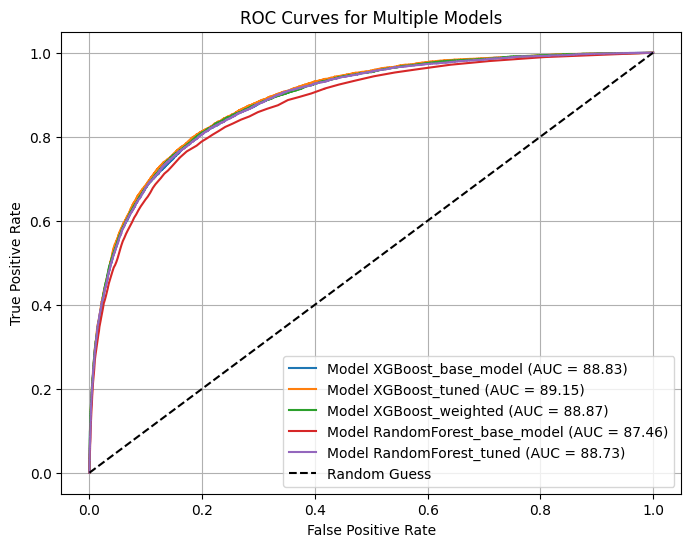

In [21]:
plt.figure(figsize=(8, 6))

# Plot the ROC curves for each model
for index, x in enumerate(predictions_val):
    label, prediction = x['label'], x['prediction']
    fpr, tpr, thresholds = roc_curve(y_test, prediction)
    auc = roc_auc_score(y_test, prediction) * 100
    plt.plot(fpr, tpr, label=f'Model {label} (AUC = {auc:.2f})')

# Plot a diagonal line representing random guess
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
